In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit


from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor as XGB
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [120]:
df = pd.read_csv("/content/drive/MyDrive/revisedweather.csv")
df


,Unnamed: 0,dt,dt_iso,temp,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_1h,snow_3h,datetime_est,dayYear,hourDay,y
0,0,283996800,1979-01-01 00:00:00 +0000 UTC,52.16,49.03,51.26,51.28,53.20,1028,89,7.05,0.0,0.0,0.0,0.0,1978-12-31 19:00:00-05:00,365,19,51.84
1,1,284000400,1979-01-01 01:00:00 +0000 UTC,51.84,48.70,50.90,51.12,52.68,1027,89,8.01,0.0,0.0,0.0,0.0,1978-12-31 20:00:00-05:00,365,20,51.48
2,2,284004000,1979-01-01 02:00:00 +0000 UTC,51.48,48.34,50.50,50.85,52.23,1027,89,8.08,0.0,0.0,0.0,0.0,1978-12-31 21:00:00-05:00,365,21,49.57
3,3,284007600,1979-01-01 03:00:00 +0000 UTC,49.57,47.91,46.24,49.21,50.22,1027,94,7.99,0.0,0.0,0.0,0.0,1978-12-31 22:00:00-05:00,365,22,49.12
4,4,284011200,1979-01-01 04:00:00 +0000 UTC,49.12,47.75,45.70,48.70,49.82,1027,95,7.96,0.0,0.0,0.0,0.0,1978-12-31 23:00:00-05:00,365,23,49.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409799,439804,1759273200,2025-09-30 23:00:00 +0000 UTC,69.10,65.39,69.84,67.44,69.80,1014,88,4.61,0.0,0.0,0.0,0.0,2025-09-30 19:00:00-04:00,273,19,69.10
409800,439806,1759276800,NaN,68.05,64.36,68.70,NaN,NaN,1014,88,4.00,0.0,0.0,0.0,0.0,2025-09-30 20:00:00-04:00,273,20,67.64
409801,439807,1759280400,NaN,67.64,63.63,68.20,NaN,NaN,1014,87,8.05,0.0,0.0,0.0,0.0,2025-09-30 21:00:00-04:00,273,21,66.74
409802,439808,1759284000,NaN,66.74,62.42,67.15,NaN,NaN,1014,86,9.22,0.0,0.0,0.0,0.0,2025-09-30 22:00:00-04:00,273,22,66.38


In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
# Lazy Baseline : Linear Regression with previous temp, hour of the Day, and Day of the year
lin = LinearRegression()
test_len = 14*24
sdf = df.copy()
traindf = sdf.iloc[:-test_len]
testdf = sdf.iloc[-test_len:]
cols = ['temp', 'hourDay', 'dayYear', 'y']
std, mean = traindf['temp'].std(), traindf['temp'].mean()
scaler = StandardScaler()

train_scaled = scaler.fit_transform(traindf[cols].values)
X_train = train_scaled[:,:-1]
y_train = traindf['y']

test_scaled = scaler.transform(testdf[cols].values)
X_test = test_scaled[:,:-1]
y_test = testdf['y']
# print(X_train_scaled)
lin.fit(X_train, y_train)

y_preds = []
length = len(testdf)
lasttemp = X_train[-1][0]
# print(lasttemp)
# add previous temperature to features for each prediction
for i in range(len(X_test)):
  X_test[i][0] = lasttemp
  # print(X_test_scaled[i]])
  y_pred = lin.predict([X_test[i]])
  y_preds.append(y_pred)
  # standardize last temp
  lasttemp = (y_pred - mean) / std

mean_absolute_error(y_test, y_preds), mean_squared_error(y_test, y_preds)


(10.806831654752107, 164.2164454034421)

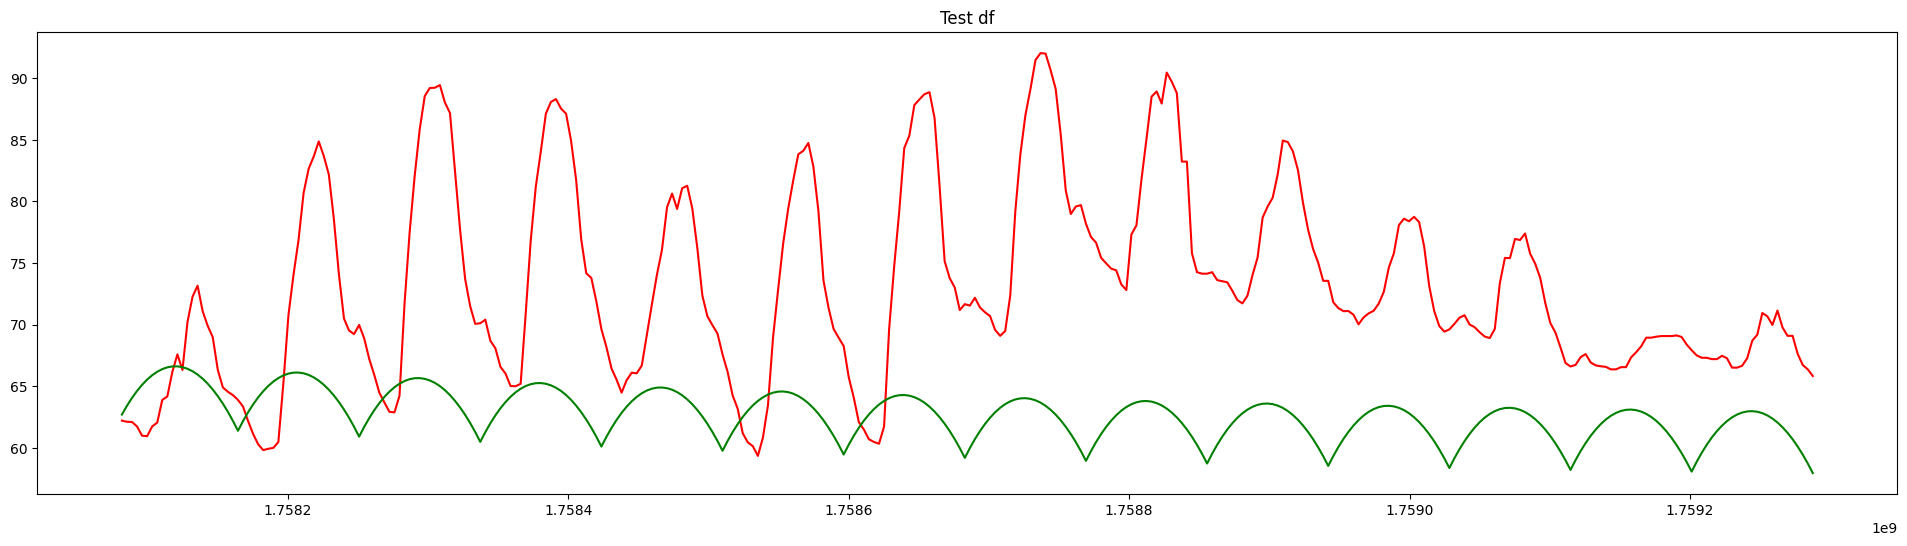

In [123]:
plt.figure(figsize=(24, 6))
# print(testdf['dt'].shape)
# print(y_pred)

plt.plot(testdf['dt'], y_test, 'r')
# plt.plot(testdf['dt'], xgb_preds, 'y')

plt.plot(testdf['dt'], y_preds, 'g')
plt.title("Test df")
plt.show();

# Discrete Fourier Transforms
Input: Time series Data points
Output: Series of complex numbers which represent discrete signals in the frequency domain.

In [124]:
def feats(df, timestamp_col, periods, K_values):
  df = df.copy()
  # Number of Fourier terms for each period

  # Create hour index from start
  df['hour_idx'] = np.arange(len(df))

  for p_name, p_len in periods.items():
      K = K_values.get(p_name, 1)

      # Create K different frequency ranges for different period lengths
      for k in range(1, K + 1):
          # Sin and cos terms
          df[f'sin_{p_name}_{k}'] = np.sin(2 * np.pi * k * df['hour_idx'] / p_len)
          df[f'cos_{p_name}_{k}'] = np.cos(2 * np.pi * k * df['hour_idx'] / p_len)

  hlags = [1, 2]
  daylags = [1*24, 2*24,  7*24]

  # Lags
  for lag in hlags:
    df[f'hour_lag_{lag}'] = df['temp'].shift(lag)
  for lag in daylags:
    df[f'day_lag_{lag}'] = df['temp'].shift(lag)

  return df

K_values = {
      'daily': 3,   # Capture daily harmonics
      'yearly': 3   # Capture seasonal variations
}
# Define periods to capture
periods = {
    'daily': 24,      # 24 hours
    'yearly': 8760    # 365 days
}
feats = feats(df, 'dt', periods, K_values)


In [125]:
feature_cols = [col for col in feats.columns if 'sin_' in col or 'cos_' in col or 'lag_' in col]
tempstd, tempmean = feats['temp'].std(), feats['temp'].mean()
print(tempstd, tempmean)
maxlag= 7*24

X = feats[feature_cols]
X['temp'] = (feats['temp'] - tempmean) / tempstd

lagcols = [col for col in feats.columns if 'lag_' in col]
for col in lagcols:
  X[col] = (X[col] - tempmean) / tempstd

# calculate exponential moving average
smoothing, days = 2, 7
alpha =  smoothing / (days+1)
X['ema'] = 0
X['ema'].iloc[0] = feats['temp'].iloc[0] * alpha
X['ema'].loc[1:] = feats['temp'] * alpha + X['ema'].shift(1) * (1-alpha)
X['ema'] = (X['ema'] - X['ema'].mean()) / X['ema'].std()

y = feats['y']
X = X.loc[maxlag:]
y = y.loc[maxlag:]

# Train-test split (use last 14 days for testing)(take out na lag values)
split_idx = len(df) - 24*14
X_train, X_test = X.loc[:split_idx], X.loc[split_idx:]
y_train, y_test = y.loc[:split_idx], y.loc[split_idx:]
print(X.columns)

16.71586510913981 60.578250724736726
Index(['sin_daily_1', 'cos_daily_1', 'sin_daily_2', 'cos_daily_2',
       'sin_daily_3', 'cos_daily_3', 'sin_yearly_1', 'cos_yearly_1',
       'sin_yearly_2', 'cos_yearly_2', 'sin_yearly_3', 'cos_yearly_3',
       'hour_lag_1', 'hour_lag_2', 'day_lag_24', 'day_lag_48', 'day_lag_168',
       'temp', 'ema'],
      dtype='object')


In [126]:
sin_cols = [col for col in feats.columns if 'sin_' in col]
cos_cols = [col for col in feats.columns if 'cos_' in col]



In [127]:
def predict(model, X_train, X_test):
  y_preds = []
  length = len(X_test)
  lasttemp, prevEMA = X_train['temp'].iloc[-1], X_train['ema'].iloc[-1]
  # tempstd, tempmean = X_train['temp'].std(), X_train['temp'].mean()

  # add previous temperature to features for each prediction
  for i in range(length):
    test_feat_set = X_test.iloc[i].copy()
    test_feat_set['temp'] = lasttemp


    #update EMA
    smoothing, days = 2, 7
    emaAlpha =  smoothing / (days+1)
    test_feat_set['ema'] = test_feat_set['temp'] * emaAlpha +  prevEMA * (1-emaAlpha)
    prevEMA = X_test['ema'].iloc[i]


    # update lag for each column
    lag_cols = [col for col in feats.columns if 'lag_' in col]
    for col in lag_cols:
      splitcol = col.split('_')
      lag = int(splitcol[-1])

      # update lag from train set if i < lag
      # We assume that the test dataset immediately follows the train dataset
      if i >= lag:
        test_feat_set[col] = X_test[col].iloc[i-lag]
      else:
        lag = lag - i
        test_feat_set[col] = X_train[col].iloc[-lag]

    # print(test_feat_set)
    ls = [test_feat_set.tolist()]

    # predictions output in arrays
    y_pred = model.predict(ls)[-1]
    # print(f"{test_feat_set}\nlasttemp:{lasttemp}, prevEMA: {prevEMA}, tempmean: {tempmean}, tempstd:{tempstd}, y_pred, {y_pred}")
    # Standardize
    lasttemp= (y_pred - tempmean) / tempstd
    y_preds.append(y_pred)

  return y_preds

def validate(m, X, y, split_idx, n_splits=10, alpha=20.0):
  if m =="Linear":
    model = LinearRegression()
  elif m =="Ridge":
    model = Ridge(alpha=alpha)
  elif m=="XGBoost":
    model = XGB(reg_lambda=alpha)
  elif m=="LGBM":
    model = LGBMRegressor()
  else:
    return "Invalid Model"

  # Train-test split (use last 14 days for testing)
  X_train_full, X_test = X.loc[:split_idx], X.loc[split_idx:]
  y_train_full, y_test = y.loc[:split_idx], y.loc[split_idx:]
  # print(y_train_full.shape[0]//5)
  tscv = TimeSeriesSplit(n_splits=n_splits, test_size=14*24)
  mse_scores = []
  for i, (train_idx, val_idx) in enumerate(tscv.split(X_train_full)):
    # Split train and favl
    X_train, X_val = X_train_full.iloc[train_idx].copy(), X_train_full.iloc[val_idx].copy()
    y_train, y_val = y_train_full.iloc[train_idx].copy(), y_train_full.iloc[val_idx].copy()
    # print(y_train, X_val, y_val)

    # fit, predict, score
    model.fit(X_train, y_train)
    preds = predict(model, X_train, X_val)
    score = mean_squared_error(preds, y_val)
    mse_scores.append(score)

  return mse_scores


In [128]:
# Ridge Regression model
ridge_val_mses = validate("Ridge", X, y, split_idx, n_splits = 10, alpha = 50.0)
mean_ridge_val_mse = np.mean(ridge_val_mses)
print(f"Ridge. Validation Scores: {ridge_val_mses}, \nMean Validation MSE:  {mean_ridge_val_mse}")

# PRedict
ridge = Ridge(alpha=50.0)
ridge.fit(X_train, y_train)
ridge_preds = predict(ridge, X_train, X_test)

# Evaluate
ridgemae = mean_absolute_error(y_test, ridge_preds)
ridgemse = mean_squared_error(y_test, ridge_preds)
print(f"Test MSE: {ridgemse}")

Ridge. Validation Scores: [11.318059619258552, 11.745025460430554, 10.826167455095137, 8.79558532618118, 9.46088245839987, 7.202744923071604, 7.490821921799268, 5.200362192175119, 9.179816428546875, 10.871055090668586], 
Mean Validation MSE:  9.209052087562675
Test MSE: 10.854054539775582


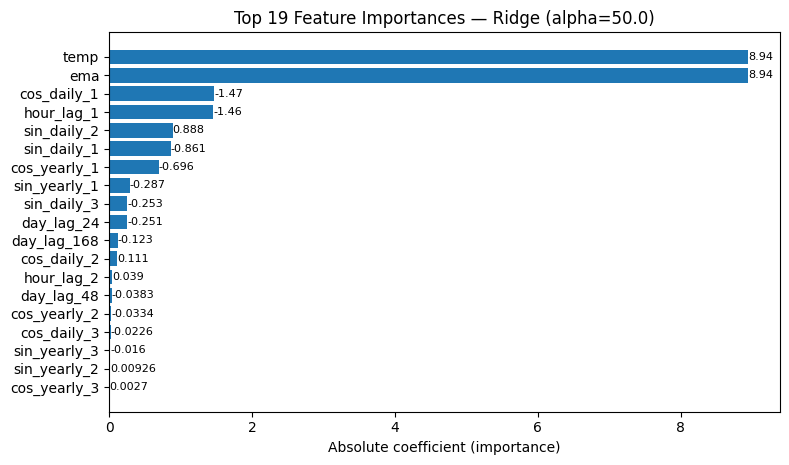

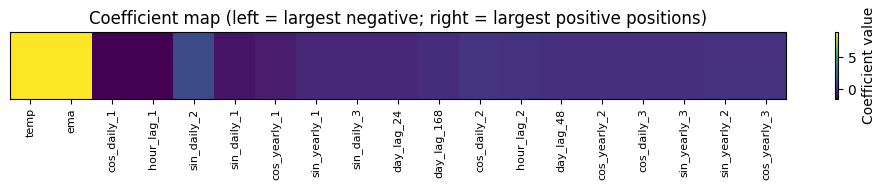

In [131]:
# get feature names
if hasattr(X_train, "columns"):
    feature_names = list(X_train.columns)
else:
    feature_names = [f"f{i}" for i in range(X_train.shape[1])]

# get coefficients
coefs = np.asarray(ridge.coef_)
if coefs.ndim > 1 and coefs.shape[0] > 1:
    coefs = coefs.mean(axis=0)
coefs = coefs.ravel()

# build importance df
importance = np.abs(coefs)
df_imp = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "importance": importance
})
df_imp = df_imp.sort_values("importance", ascending=False).reset_index(drop=True)

# Bar chart
n_plot = len(df_imp)
df_top = df_imp.iloc[:n_plot].copy()
df_top = df_top[::-1]  # reverse for horizontal bar ordering (smallest at top)

plt.figure(figsize=(8, max(3, n_plot * 0.25)))
plt.barh(df_top["feature"], df_top["importance"])
plt.xlabel("Absolute coefficient (importance)")
plt.title(f"Top {n_plot} Feature Importances — Ridge (alpha={ridge.alpha})")

# annotate numeric coefficient values
for i, (imp, coef) in enumerate(zip(df_top["importance"], df_top["coef"])):
    plt.gca().text(imp + 1e-12, i, f"{coef:.3g}", va="center", fontsize=8)
plt.tight_layout()
plt.show()

# Coefficient map

plt.figure(figsize=(max(10, len(feature_names) * 0.15), 2))
coef_row = df_imp["coef"].values.reshape(1, -1)
plt.imshow(coef_row, aspect="auto")
plt.gca().set_yticks([])
plt.xticks(ticks=np.arange(len(df_imp)), labels=df_imp["feature"], rotation=90, fontsize=8)
plt.title("Coefficient map (left = largest negative; right = largest positive positions)")
plt.colorbar(label="Coefficient value")
plt.tight_layout()
plt.show()

In [130]:
# XGBoost Model
xgb_val_mses = validate("XGBoost", X, y, split_idx, n_splits = 10, alpha = 50.0)
mean_xgb_val_mse = np.mean(ridge_val_mses)
print(f"Ridge. Validation Scores: {ridge_val_mses}, \nMean Validation MSE:  {mean_ridge_val_mse}")

# Predict
xgb = XGB(reg_lambda=i)
xgb.fit(X_train, y_train)
xgb_preds = predict(xgb, X_train, X_test)
# Evaluate
xgbmae = mean_absolute_error(y_test, xgb_preds)
xgbmse = mean_squared_error(y_test, xgb_preds)
print(f"Test MSE: {xgbmse}")
print(f"XGBoost. Validation Scores: {xgb_val_mses}, \nMean Validation MSE:  {mean_xgb_val_mse}, Test MSE: {xgbmse}")

Ridge. Validation Scores: [11.318059619258552, 11.745025460430554, 10.826167455095137, 8.79558532618118, 9.46088245839987, 7.202744923071604, 7.490821921799268, 5.200362192175119, 9.179816428546875, 10.871055090668586], 
Mean Validation MSE:  9.209052087562675
Test MSE: 1286.415093141574
XGBoost. Validation Scores: [2050.783452517067, 1873.7521825919666, 66.22570084082412, 2136.3377058986816, 44.69328369993888, 14.67857240073751, 52.12928329886912, 1065.496695816053, 1516.243722573053, 1254.1721628057098], 
Mean Validation MSE:  9.209052087562675, Test MSE: 1286.415093141574


In [ ]:
# LightGBM
# Predict
lgb = LGBMRegressor(reg_lambda=i)
lgb.fit(X_train, y_train)
lgb_preds = predict(lgb, X_train, X_test)
print(f"LGBM  LGBM Test MSE: {mean_squared_error(y_test, lgb_preds)}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 409301, number of used features: 19
[LightGBM] [Info] Start training from score 60.570185
LGBM  LGBM Test MSE: 431.839858996132


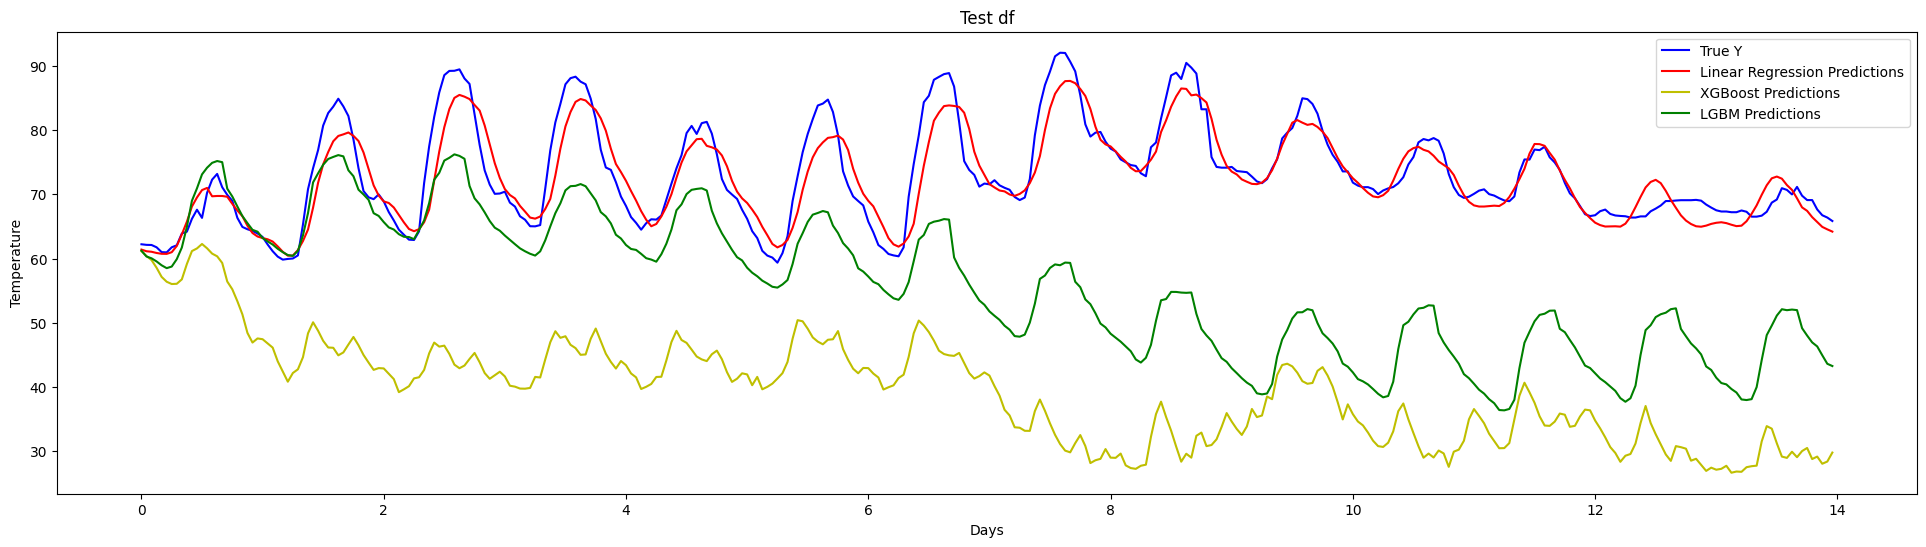

In [ ]:
plt.figure(figsize=(24, 6))
days =  (testdf['dt'] - testdf['dt'].iloc[0]) / (3600*24)

plt.plot(days, testdf['y'], 'b', label= 'True Y')
plt.plot(days, ridge_preds, 'r', label = "Linear Regression Predictions")
plt.plot(days, xgb_preds, 'y', label = 'XGBoost Predictions')
plt.plot(days, lgb_preds, 'g', label = 'LGBM Predictions')

plt.ylabel("Temperature")
plt.xlabel("Days")
plt.legend()
plt.title("Test df")
plt.show();